# MRI Brain Tumour Classifier based on DenseNet Transfer learning

References:
- [Reference 1](https://www.kaggle.com/code/abdoghazala/brain-tumor-detection-classification-cnn-97-6)


In [1]:
# Import packages
import os
import random
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore

import matplotlib.pyplot as plt
from utils import *

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.layers as tfl
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.applications import DenseNet121


from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold, KFold


In [2]:
# Preprocessing

IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Train
training_set = tf.keras.utils.image_dataset_from_directory(
    DATASET_FOLDER,
    validation_split = 0.2,
    subset="training",
    shuffle=True,
    seed=19032024,
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = BATCH_SIZE,
    label_mode = 'categorical'
)
# Validation
validate_set = tf.keras.utils.image_dataset_from_directory(
    DATASET_FOLDER,
    validation_split = 0.2,
    subset="validation",
    shuffle=True,
    seed=19032024,
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = BATCH_SIZE,
    label_mode = 'categorical'

)

test_set = tf.keras.utils.image_dataset_from_directory(
    DATASET_FOLDER,
    shuffle=False,
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = BATCH_SIZE,
    label_mode = 'categorical'
)

# Prefetch the train_dataset
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = training_set.prefetch(buffer_size=AUTOTUNE)
validation_dataset = training_set.prefetch(buffer_size=AUTOTUNE)


Found 480 files belonging to 4 classes.
Using 384 files for training.
Found 480 files belonging to 4 classes.
Using 96 files for validation.
Found 480 files belonging to 4 classes.


In [3]:
class_names = training_set.class_names
print(class_names)
class_names = validate_set.class_names
print(class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']
['glioma', 'meningioma', 'notumor', 'pituitary']


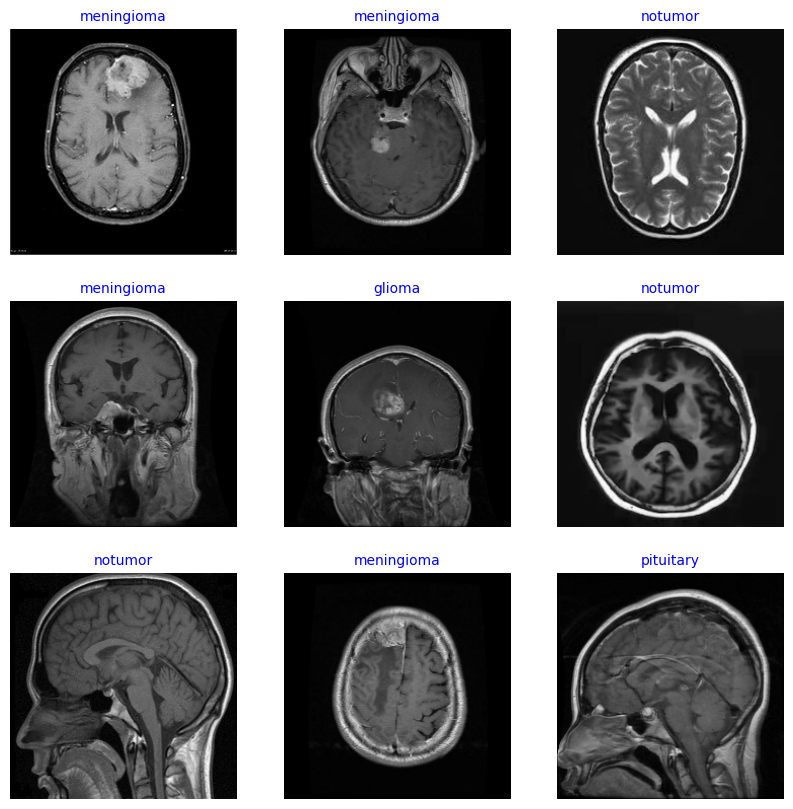

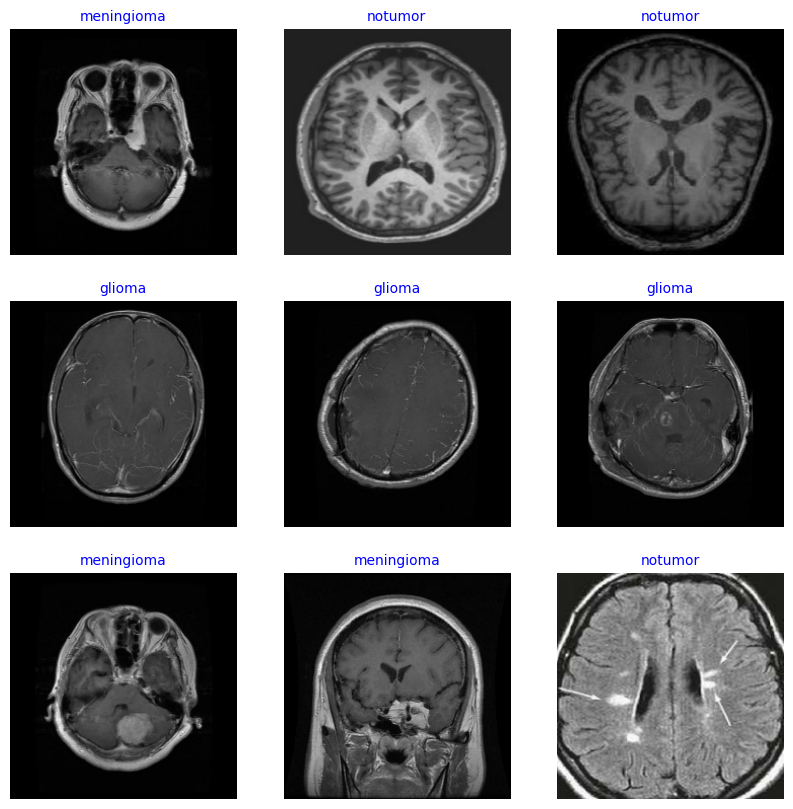

In [4]:
# View images of dataset
class_names = test_set.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])] , c = 'blue' , size = 10)
    plt.axis("off")

plt.figure(figsize=(10, 10))
for images, labels in validation_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])] , c = 'blue' , size = 10)
    plt.axis("off")

Models

In [5]:
# Hyperparameters
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH) + (3,)
LOSS = keras.losses.CategoricalCrossentropy()
OPTIMIZER = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
SEED = 42

In [6]:
# # callbacks for the models
# def get_callbacks (model_name):
#   callbacks = []
#   checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath= f'{model_name}', monitor = 'val_loss', verbose = 1 ,
#                                                     mode = 'min', save_best_only=True, save_freq='epoch')
#   callbacks.append(checkpoint)
#   rlr = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss', factor=0.2, patience=5, mode='auto', min_lr=0.0)
#   callbacks.append(rlr)
#   earlystop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 7)
#   callbacks.append(earlystop)

#   return callbacks

early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)


In [7]:
# function for plot resultes

def plot():
   pd.DataFrame(history.history)[['categorical_accuracy','val_categorical_accuracy','loss','val_loss']].plot( figsize=(7, 5), xlim=[0, 9], ylim=[0, 1], grid=True, xlabel="Epoch", style=["r--", "r--.", "b-", "b-*"])
   plt.show()

# for make dataframe for densenet model
model_name= 'DenseNet121'
CategoricalAccuracy= []
losses= []

## Densenet Portion

In [8]:
def preprocess_data(image, label):
    return preprocess_input(image), label
    

train_dataset_densenet = train_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)
validation_dataset_densenet = validation_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)
test_dataset_densenet = test_set.map(preprocess_data, num_parallel_calls=AUTOTUNE)

dense_model = DenseNet121(weights='imagenet', include_top=False, input_shape= IMG_SHAPE , classes = 4)
dense_model.trainable = False

x = dense_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
# Add dropout layers to prevent the model from becoming too reliant on any one neuron
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=dense_model.input, outputs=predictions)

model.compile(optimizer= OPTIMIZER, loss= LOSS, metrics=[keras.metrics.CategoricalAccuracy() , keras.metrics.Recall()])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,300,932 (27.85 MB)

 Trainable params: 263,428 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [9]:
# callbacks = get_callbacks('DenseNet121')

history = model.fit(
    train_dataset_densenet,
    epochs=10,
    validation_data=validation_dataset_densenet,
)

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 67s 4s/step - categorical_accuracy: 0.3181 - loss: 1.9706 - recall: 0.2624 - val_categorical_accuracy: 0.7474 - val_loss: 0.6782 - val_recall: 0.6198
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - categorical_accuracy: 0.6715 - loss: 0.8178 - recall: 0.6282 - val_categorical_accuracy: 0.8073 - val_loss: 0.5006 - val_recall: 0.7318
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - categorical_accuracy: 0.7896 - loss: 0.5667 - recall: 0.7306 - val_categorical_accuracy: 0.9036 - val_loss: 0.3749 - val_recall: 0.8620
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - categorical_accuracy: 0.7980 - loss: 0.5043 - recall: 0.7456 - val_categorical_accuracy: 0.9245 - val_loss: 0.3379 - val_recall: 0.8880
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - categorical_accuracy: 0.8345 - loss: 0.4666 - recall: 0.7601 - val_categorical_accuracy: 0.8750 - val_loss: 0.3403 - val_recall: 0.8255
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - categori

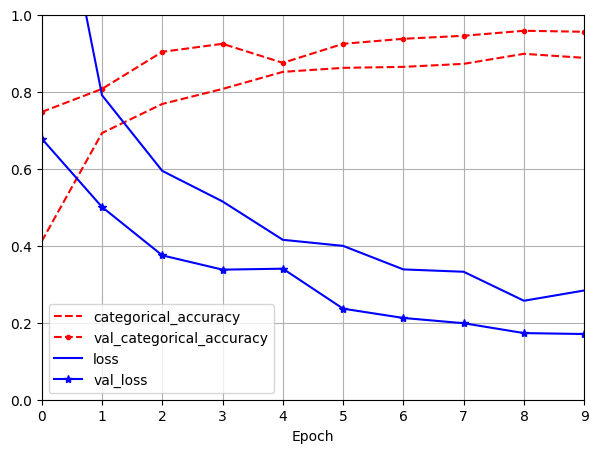

15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - categorical_accuracy: 0.9287 - loss: 0.2296 - recall: 0.9206


In [10]:
plot()

# Test metrics
loss, val_categorical_accuracy, recall = model.evaluate(test_dataset_densenet)
CategoricalAccuracy.append(val_categorical_accuracy)
losses.append(loss)

In [11]:
# Saving the model

# Create the directory if it doesn't exist
save_dir = 'model/'
os.makedirs(save_dir, exist_ok=True)

model.save(os.path.join(save_dir, 'densenet121.keras'))


## Fine Tuning Densenet-121 model

In [12]:
densenet_tuning = keras.models.load_model('./model/densenet121.keras')

In [13]:
# Unfreeze more layers to prevent over fitting
for layer in densenet_tuning.layers[:10]:
    layer.trainable = False

for layer in densenet_tuning.layers[10:]:
    layer.trainable = True

# smaller learning rate for fine-tuning
new_optimizer = optimizers.Adam(learning_rate=0.00001)
densenet_tuning.compile(optimizer=new_optimizer,loss=LOSS,metrics=['accuracy'])

history_densenet = densenet_tuning.fit(
    train_dataset_densenet,
    epochs = 10,
    validation_data = validation_dataset_densenet,
    callbacks = [early_stopping]
)

Epoch 1/10


12/12 ━━━━━━━━━━━━━━━━━━━━ 222s 9s/step - accuracy: 0.5826 - loss: 1.0524 - val_accuracy: 0.9609 - val_loss: 0.1673
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 98s 8s/step - accuracy: 0.7184 - loss: 0.7184 - val_accuracy: 0.9531 - val_loss: 0.1666
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 100s 8s/step - accuracy: 0.7959 - loss: 0.5683 - val_accuracy: 0.9453 - val_loss: 0.1715
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 105s 9s/step - accuracy: 0.8830 - loss: 0.3567 - val_accuracy: 0.9401 - val_loss: 0.1864
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 99s 8s/step - accuracy: 0.9153 - loss: 0.2428 - val_accuracy: 0.9453 - val_loss: 0.1997
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 98s 8s/step - accuracy: 0.9256 - loss: 0.2059 - val_accuracy: 0.9323 - val_loss: 0.2133
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 93s 8s/step - accuracy: 0.9429 - loss: 0.1822 - val_accuracy: 0.9219 - val_loss: 0.2285
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 88s 7s/step - accuracy: 0.9749 - loss: 0.1284 - val_accuracy: 0.9167 - val_loss: 0.2388


In [14]:
loss, val_categorical_accuracy = densenet_tuning.evaluate(test_dataset_densenet)

15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9313 - loss: 0.2357


In [15]:
# Extract validation accuracy and loss from the history object
val_accuracies = history_densenet.history['val_accuracy']
val_losses = history_densenet.history['val_loss']

# Find the best validation accuracy and the corresponding epoch
best_val_accuracy = max(val_accuracies)
best_val_accuracy_epoch = val_accuracies.index(best_val_accuracy) + 1  # Epochs start at 1

# Find the lowest validation loss and the corresponding epoch
lowest_val_loss = min(val_losses)
lowest_val_loss_epoch = val_losses.index(lowest_val_loss) + 1  # Epochs start at 1

# Print the results
print(f"Best Validation Accuracy: {best_val_accuracy:.4f} at Epoch {best_val_accuracy_epoch}")
print(f"Lowest Validation Loss: {lowest_val_loss:.4f} at Epoch {lowest_val_loss_epoch}")

Best Validation Accuracy: 0.9609 at Epoch 1
Lowest Validation Loss: 0.1666 at Epoch 2


In [16]:
# For model evaluation in confusion matrix
y_true = np.concatenate([ y for _ , y in test_set] , axis = 0)

In [17]:
y_true = np.argmax(y_true, axis=1)
y_pred = densenet_tuning.predict(test_dataset_densenet)
y_pred = np.argmax(y_pred, axis=1)

15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step


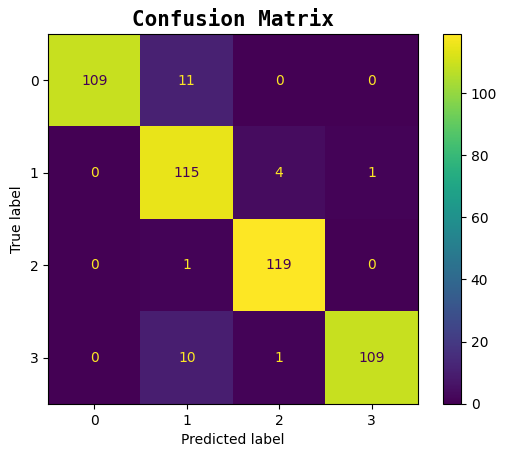

In [18]:
from sklearn.metrics import confusion_matrix , classification_report , ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_true , y_pred)
plt.title("Confusion Matrix", fontname = "monospace", fontsize = 15, weight = "bold")
plt.show()

In [19]:
print("\nClassification Report:\n")
print(Fore.BLUE + classification_report(y_true, y_pred, target_names = class_names, digits= 4))


Classification Report:

              precision    recall  f1-score   support

      glioma     1.0000    0.9083    0.9520       120
  meningioma     0.8394    0.9583    0.8949       120
     notumor     0.9597    0.9917    0.9754       120
   pituitary     0.9909    0.9083    0.9478       120

    accuracy                         0.9417       480
   macro avg     0.9475    0.9417    0.9425       480
weighted avg     0.9475    0.9417    0.9425       480



In [20]:
# Save the finetuned model

# Create the directory if it doesn't exist
save_dir = 'model/'
os.makedirs(save_dir, exist_ok=True)

densenet_tuning.save(os.path.join(save_dir, 'finetuned_densenet121.keras'))


## K-Fold Cross Validation

In [23]:
# attempt

import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import image_dataset_from_directory

# Load dataset without validation split
dataset = image_dataset_from_directory(
    DATASET_FOLDER,
    shuffle=True,
    seed=RANDOM_STATE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# Convert dataset to numpy arrays for k-fold splitting
images = []
labels = []
for image, label in dataset:
    images.append(image.numpy())
    labels.append(label.numpy())
images = np.concatenate(images)
labels = np.concatenate(labels)

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Initialize lists to store results
list_kf_results = []

print("K-Fold Cross-Validation")
fold_no = 1
for train_index, val_index in kf.split(images):
    # Split data
    train_images, val_images = images[train_index], images[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]
    
    # Create TensorFlow datasets
    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

    # Prefetch datasets
    train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
# 
    # Reload the fine-tuned model
    model = load_model('model/finetuned_densenet121.keras')
    
    # Train the model if needed (optional, usually re-evaluate)
    history = model.fit(train_ds, validation_data=val_ds, epochs=10, batch_size=BATCH_SIZE, verbose=0)
    
    # Evaluate the model
    train_loss, train_accuracy = model.evaluate(train_ds, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_ds, verbose=0)
    
    # Save results
    list_kf_results.append({
        "train_loss": train_loss, 
        "train_accuracy": train_accuracy, 
        "val_loss": val_loss, 
        "val_accuracy": val_accuracy, 
        # "history": history if history else None
    })
    
    print("Fold Index", fold_no)
    print("~Training Dataset~\nAccuracy: {}, Loss: {}".format(train_accuracy, train_loss))
    print("~Validation Dataset~\nAccuracy: {}, Loss: {}".format(val_accuracy, val_loss), end="\n\n")
    
    # Increment fold number
    fold_no += 1

# Calculate and print the average results
avg_train_accuracy = np.mean([result['train_accuracy'] for result in list_kf_results])
avg_val_accuracy = np.mean([result['val_accuracy'] for result in list_kf_results])
avg_train_loss = np.mean([result['train_loss'] for result in list_kf_results])
avg_val_loss = np.mean([result['val_loss'] for result in list_kf_results])

print(f"Average Training Accuracy: {avg_train_accuracy:.4f}")
print(f"Average Validation Accuracy: {avg_val_accuracy:.4f}")
print(f"Average Training Loss: {avg_train_loss:.4f}")
print(f"Average Validation Loss: {avg_val_loss:.4f}")


Found 480 files belonging to 4 classes.
K-Fold Cross-Validation
Fold Index 1
~Training Dataset~
Accuracy: 0.9713541865348816, Loss: 0.1417931467294693
~Validation Dataset~
Accuracy: 0.84375, Loss: 0.3823438882827759

Fold Index 2
~Training Dataset~
Accuracy: 0.9401041865348816, Loss: 0.1717492789030075
~Validation Dataset~
Accuracy: 0.90625, Loss: 0.2718111276626587

Fold Index 3
~Training Dataset~
Accuracy: 0.9479166865348816, Loss: 0.16424302756786346
~Validation Dataset~
Accuracy: 0.8854166865348816, Loss: 0.31335654854774475

Fold Index 4
~Training Dataset~
Accuracy: 0.9505208134651184, Loss: 0.16676564514636993
~Validation Dataset~
Accuracy: 0.8645833134651184, Loss: 0.32873257994651794

Fold Index 5
~Training Dataset~
Accuracy: 0.9453125, Loss: 0.15081171691417694
~Validation Dataset~
Accuracy: 0.8854166865348816, Loss: 0.35709676146507263

Average Training Accuracy: 0.9510
Average Validation Accuracy: 0.8771
Average Training Loss: 0.1591
Average Validation Loss: 0.3307


In [32]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.model_selection import StratifiedKFold

# Load dataset without validation split
dataset = image_dataset_from_directory(
    DATASET_FOLDER,
    shuffle=True,
    seed=RANDOM_STATE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# Convert dataset to numpy arrays for k-fold splitting
images = []
labels = []
for image, label in dataset:
    images.append(image.numpy())
    labels.append(label.numpy())
images = np.concatenate(images)
labels = np.concatenate(labels)

# K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Initialize lists to store results
list_skf_results = []

print("Stratified K-Fold Cross-Validation")
fold_no = 0
for train_index, val_index in skf.split(images, np.argmax(labels, axis=1)):
    # Split data
    train_images, val_images = images[train_index], images[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]
    
    # Create TensorFlow datasets
    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

    # Prefetch datasets
    train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

    # Reload the fine-tuned model
    model = load_model('model/finetuned_densenet121.keras')
    
    # Train the model if needed (optional, usually re-evaluate)
    history = model.fit(train_ds, validation_data=val_ds, epochs=10, verbose=0)
    
    # Evaluate the model
    train_loss, train_accuracy = model.evaluate(train_ds, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_ds, verbose=0)
    
    # Save results
    list_skf_results.append({
        "train_loss": train_loss, 
        "train_accuracy": train_accuracy, 
        "val_loss": val_loss, 
        "val_accuracy": val_accuracy, 
    })
    
    print("Fold Index", fold_no)
    print("~Training Dataset~\nAccuracy: {}, Loss: {}".format(train_accuracy, train_loss))
    print("~Validation Dataset~\nAccuracy: {}, Loss: {}".format(val_accuracy, val_loss), end="\n\n")
    
    # Increment fold number
    fold_no += 1


Found 480 files belonging to 4 classes.
Stratified K-Fold Cross-Validation
Fold Index 0
~Training Dataset~
Accuracy: 0.9635416865348816, Loss: 0.1338237226009369
~Validation Dataset~
Accuracy: 0.8229166865348816, Loss: 0.5376132130622864

Fold Index 1
~Training Dataset~
Accuracy: 0.9453125, Loss: 0.17348343133926392
~Validation Dataset~
Accuracy: 0.875, Loss: 0.3637140691280365

Fold Index 2
~Training Dataset~
Accuracy: 0.9479166865348816, Loss: 0.16384907066822052
~Validation Dataset~
Accuracy: 0.875, Loss: 0.2642015516757965

Fold Index 3
~Training Dataset~
Accuracy: 0.9505208134651184, Loss: 0.16704882681369781
~Validation Dataset~
Accuracy: 0.9166666865348816, Loss: 0.24549101293087006

Fold Index 4
~Training Dataset~
Accuracy: 0.9505208134651184, Loss: 0.16660702228546143
~Validation Dataset~
Accuracy: 0.8854166865348816, Loss: 0.3069450557231903

Average Training Accuracy: nan
Average Validation Accuracy: nan
Average Training Loss: nan
Average Validation Loss: nan


c:\Users\stand\OneDrive\Documents\School\Y2T3\ML\CSC3109-ML\.venv\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\stand\OneDrive\Documents\School\Y2T3\ML\CSC3109-ML\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [33]:
# Calculate and print the average results
avg_train_accuracy = np.mean([result['train_accuracy'] for result in list_skf_results])
avg_val_accuracy = np.mean([result['val_accuracy'] for result in list_skf_results])
avg_train_loss = np.mean([result['train_loss'] for result in list_skf_results])
avg_val_loss = np.mean([result['val_loss'] for result in list_skf_results])

print(f"Average Training Accuracy: {avg_train_accuracy:.4f}")
print(f"Average Validation Accuracy: {avg_val_accuracy:.4f}")
print(f"Average Training Loss: {avg_train_loss:.4f}")
print(f"Average Validation Loss: {avg_val_loss:.4f}")

Average Training Accuracy: 0.9516
Average Validation Accuracy: 0.8750
Average Training Loss: 0.1610
Average Validation Loss: 0.3436


In [35]:
model.save(os.path.join(save_dir, 'densenet_model.keras'))
